In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.optimize import Bounds
import warnings

In [2]:
warnings.filterwarnings("ignore")

### Ground Truth Positions

In [3]:
x_A = 0.0 * np.ones(130)
y_A = np.linspace(0, 13, 130, endpoint=False)

In [4]:
x_B = np.linspace(0, 5, 50, endpoint=False)
y_B = 13.0 * np.ones(50)

In [5]:
x_C = 5.0 * np.ones(40)
y_C = np.linspace(13, 9, 40, endpoint=False)

In [6]:
x_D = np.linspace(5, -5, 100, endpoint=False)
y_D = 9.0 * np.ones(100)

In [7]:
x_E = -5.0 * np.ones(70)
y_E = np.linspace(9, 2, 70, endpoint=False)

In [8]:
x_F = np.linspace(-5, 3, 81, endpoint=True)
y_F = 2.0 * np.ones(81)

In [9]:
t_values = np.arange(0, 2*np.pi + 0.01, 0.01)
# Calculate x and y coordinates using the parametric equations
x_gt = [7.5*np.sin(t) for t in t_values]
y_gt = [7.5 + 7.5*np.sin(2 * t) for t in t_values]

In [10]:
# Create the dictionary using a dictionary comprehension
gt = {key: [x_gt[key], y_gt[key]] for key in range(len(x_gt))}

### Odometry Positions (GT + Bias + Noise)

In [11]:
x_odometer = np.zeros(len(x_gt))
y_odometer = np.zeros(len(y_gt))

In [12]:
odometer_std = 0.001 # noise
odometer_bias = 0.002

In [13]:
for i in range(1, len(x_odometer)):
    # Relative measurement by odometer + noise + bias
    x_odometer[i] = (x_gt[i] - x_gt[i-1]) + np.random.normal(0, odometer_std) + odometer_bias
    y_odometer[i] = (y_gt[i] - y_gt[i-1]) + np.random.normal(0, odometer_std) + odometer_bias

In [14]:
x_odometry = np.zeros(len(x_gt))
y_odometry = np.zeros(len(y_gt))

In [15]:
for i in range(1, len(x_gt)):
    # Dead recokning
    x_odometry[i] = x_odometry[i-1] + x_odometer[i]
    y_odometry[i] = y_odometry[i-1] + y_odometer[i]

In [16]:
nodes_robot = {key: [x_odometry[key], y_odometry[key]] for key in range(len(x_odometry))}

### Landmark Positions (Map)

In [17]:
x_AP = np.array([-8.0, 8.0, -9.0, 9.0, -9.0, 8.0])
y_AP = np.array([0.0, 0.0, 6.0, 7.0, 13.0, 14.0])

In [18]:
nodes_AP = {key: [x_AP[key], y_AP[key]] for key in range(len(x_AP))}

### Plot GT Positions and Landmarks

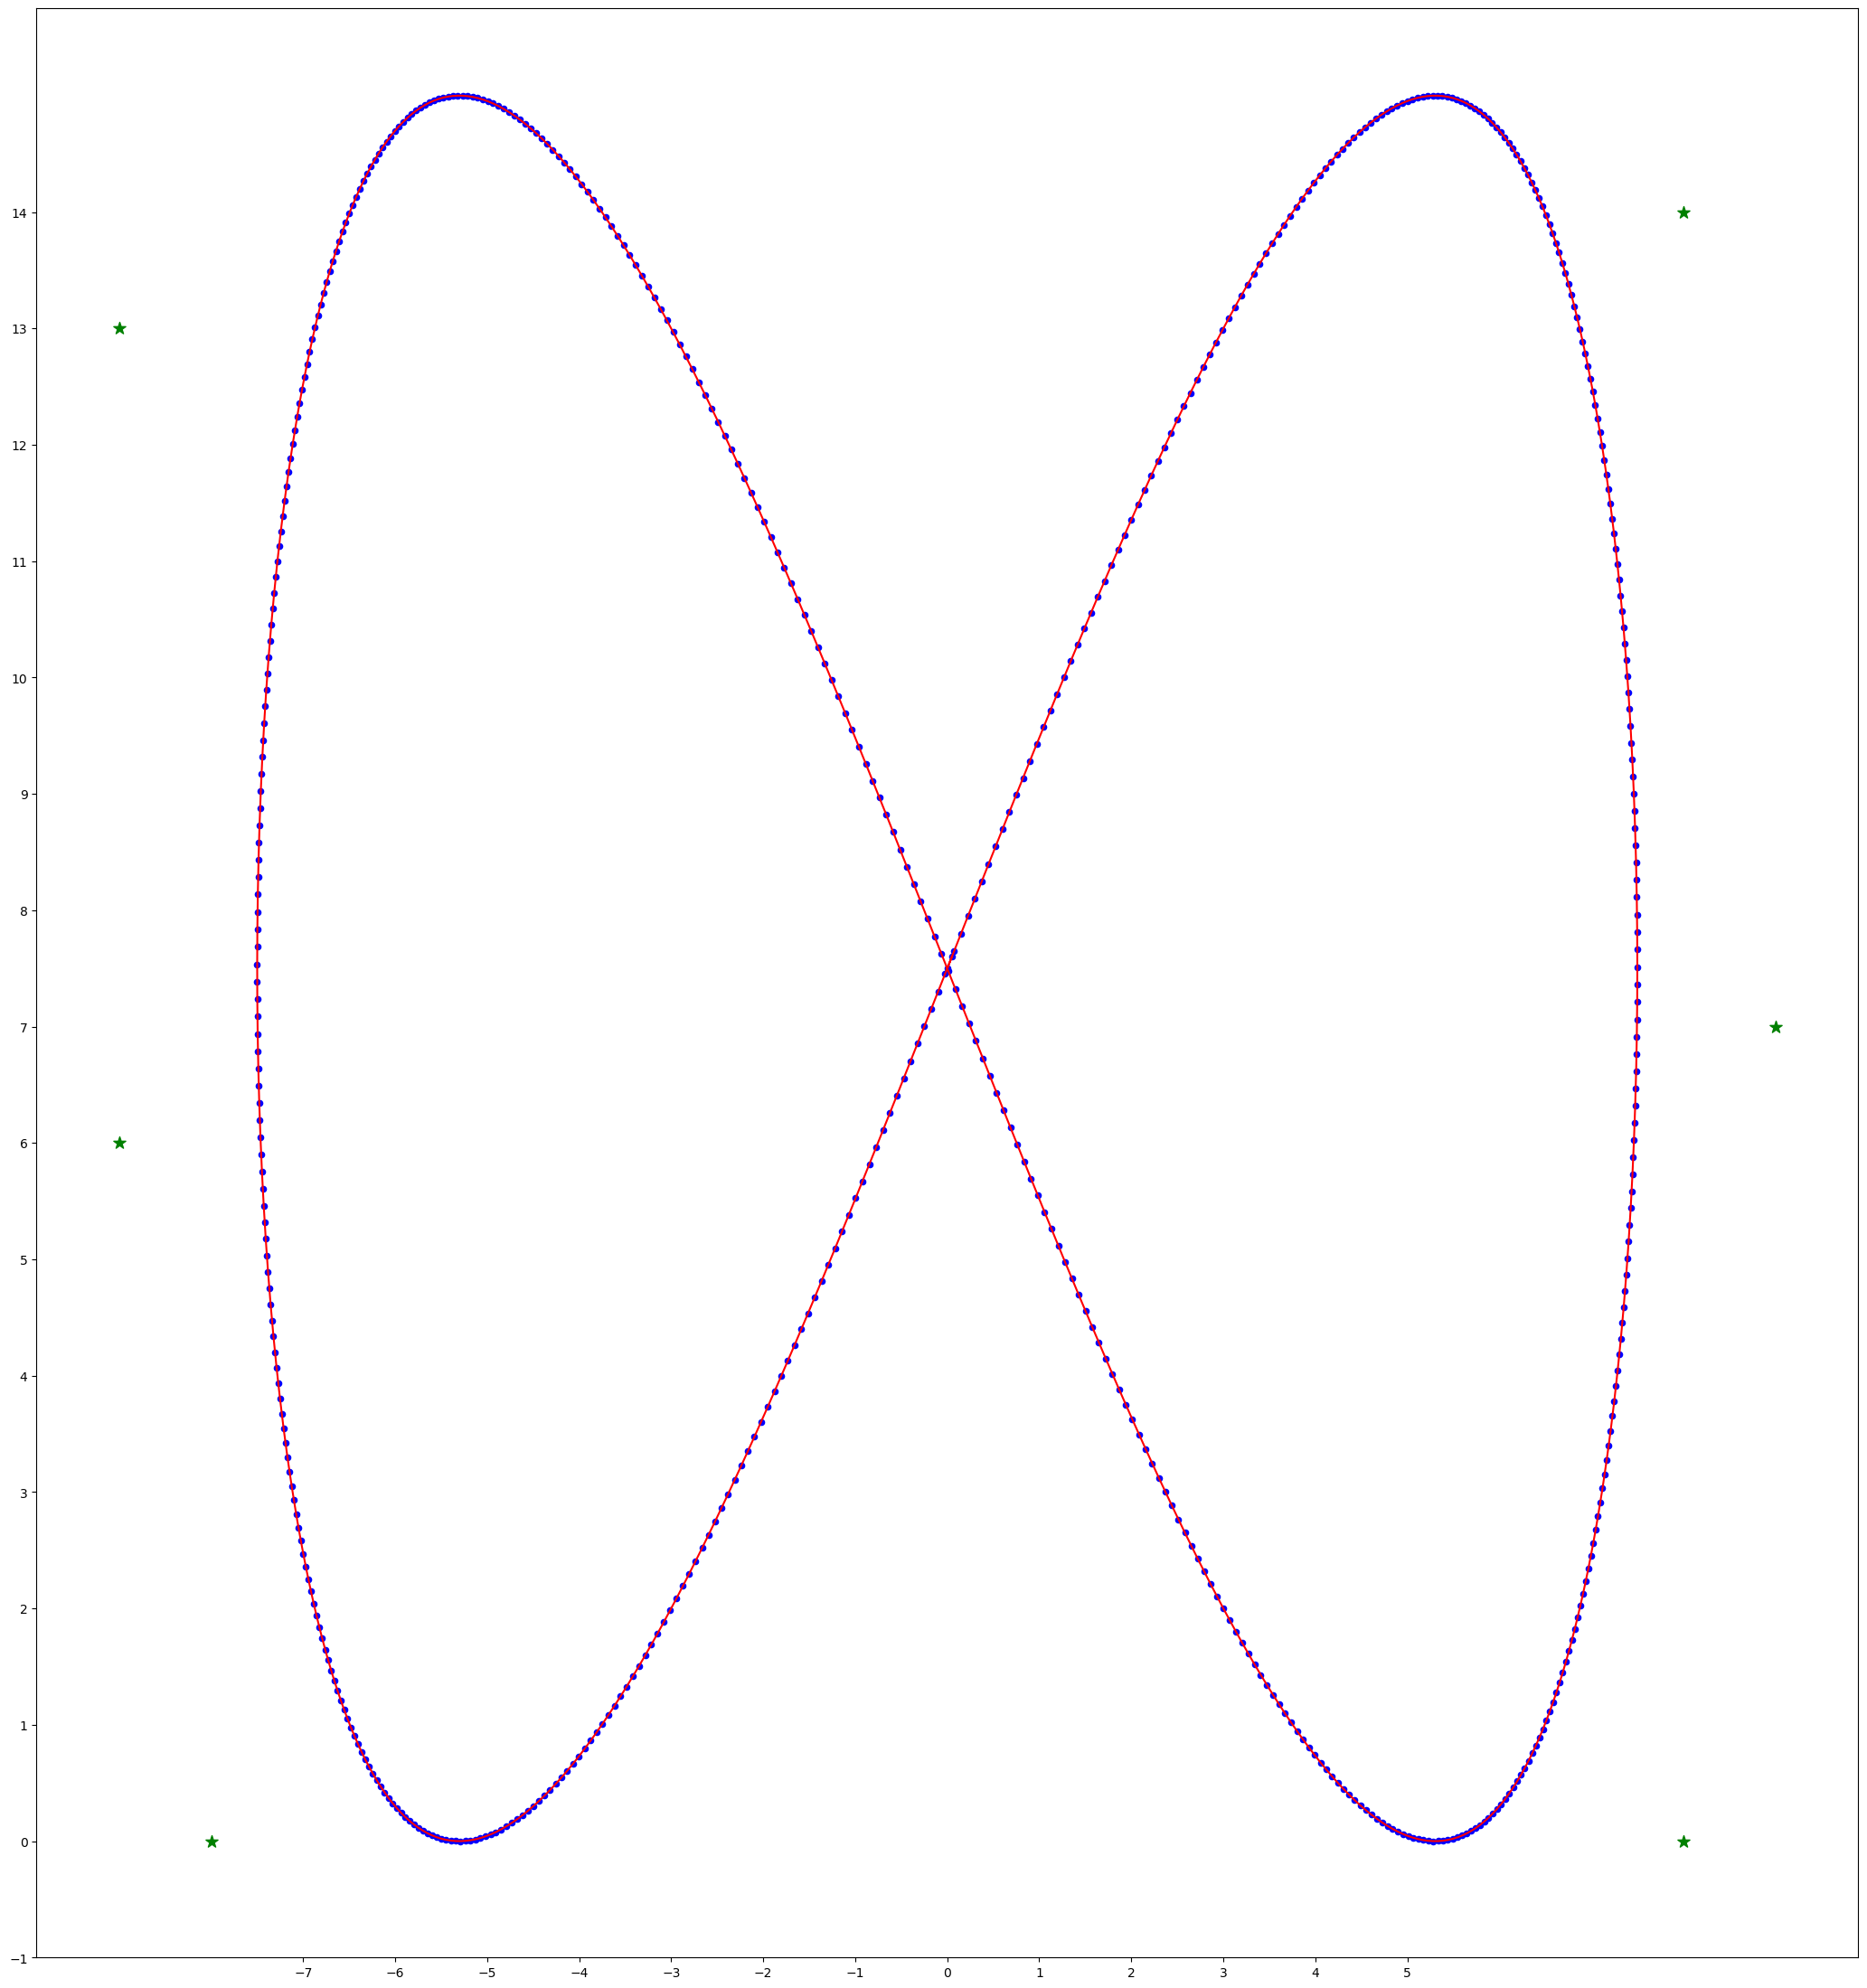

In [19]:
# Create a larger figure
plt.figure(figsize=(26, 28))  # Adjust the figsize (width, height) as needed

x_gt = [value[0] for value in gt.values()]
y_gt = [value[1] for value in gt.values()]

# Create a scatter plot with blue circles
plt.scatter(x_gt, y_gt, color='blue', marker='o', s=20)

# Create red lines connecting the points
plt.plot(x_gt, y_gt, color='red')


######################### APs ##########################
x_AP = [value[0] for value in nodes_AP.values()]
y_AP = [value[1] for value in nodes_AP.values()]
plt.scatter(x_AP, y_AP, color='green', marker='*', s=100)
########################################################

# Set custom tick positions and labels for the x-axis
x_ticks_positions = np.arange(-7, 6, 1)  # Start at 0, end at 6 (exclusive), step by 1
plt.xticks(x_ticks_positions)

# Set custom tick positions and labels for the y-axis
y_ticks_positions = np.arange(-1, 15, 1)
plt.yticks(y_ticks_positions)

# Show the plot
plt.show()


### Plot Odometry Positions and Landmarks

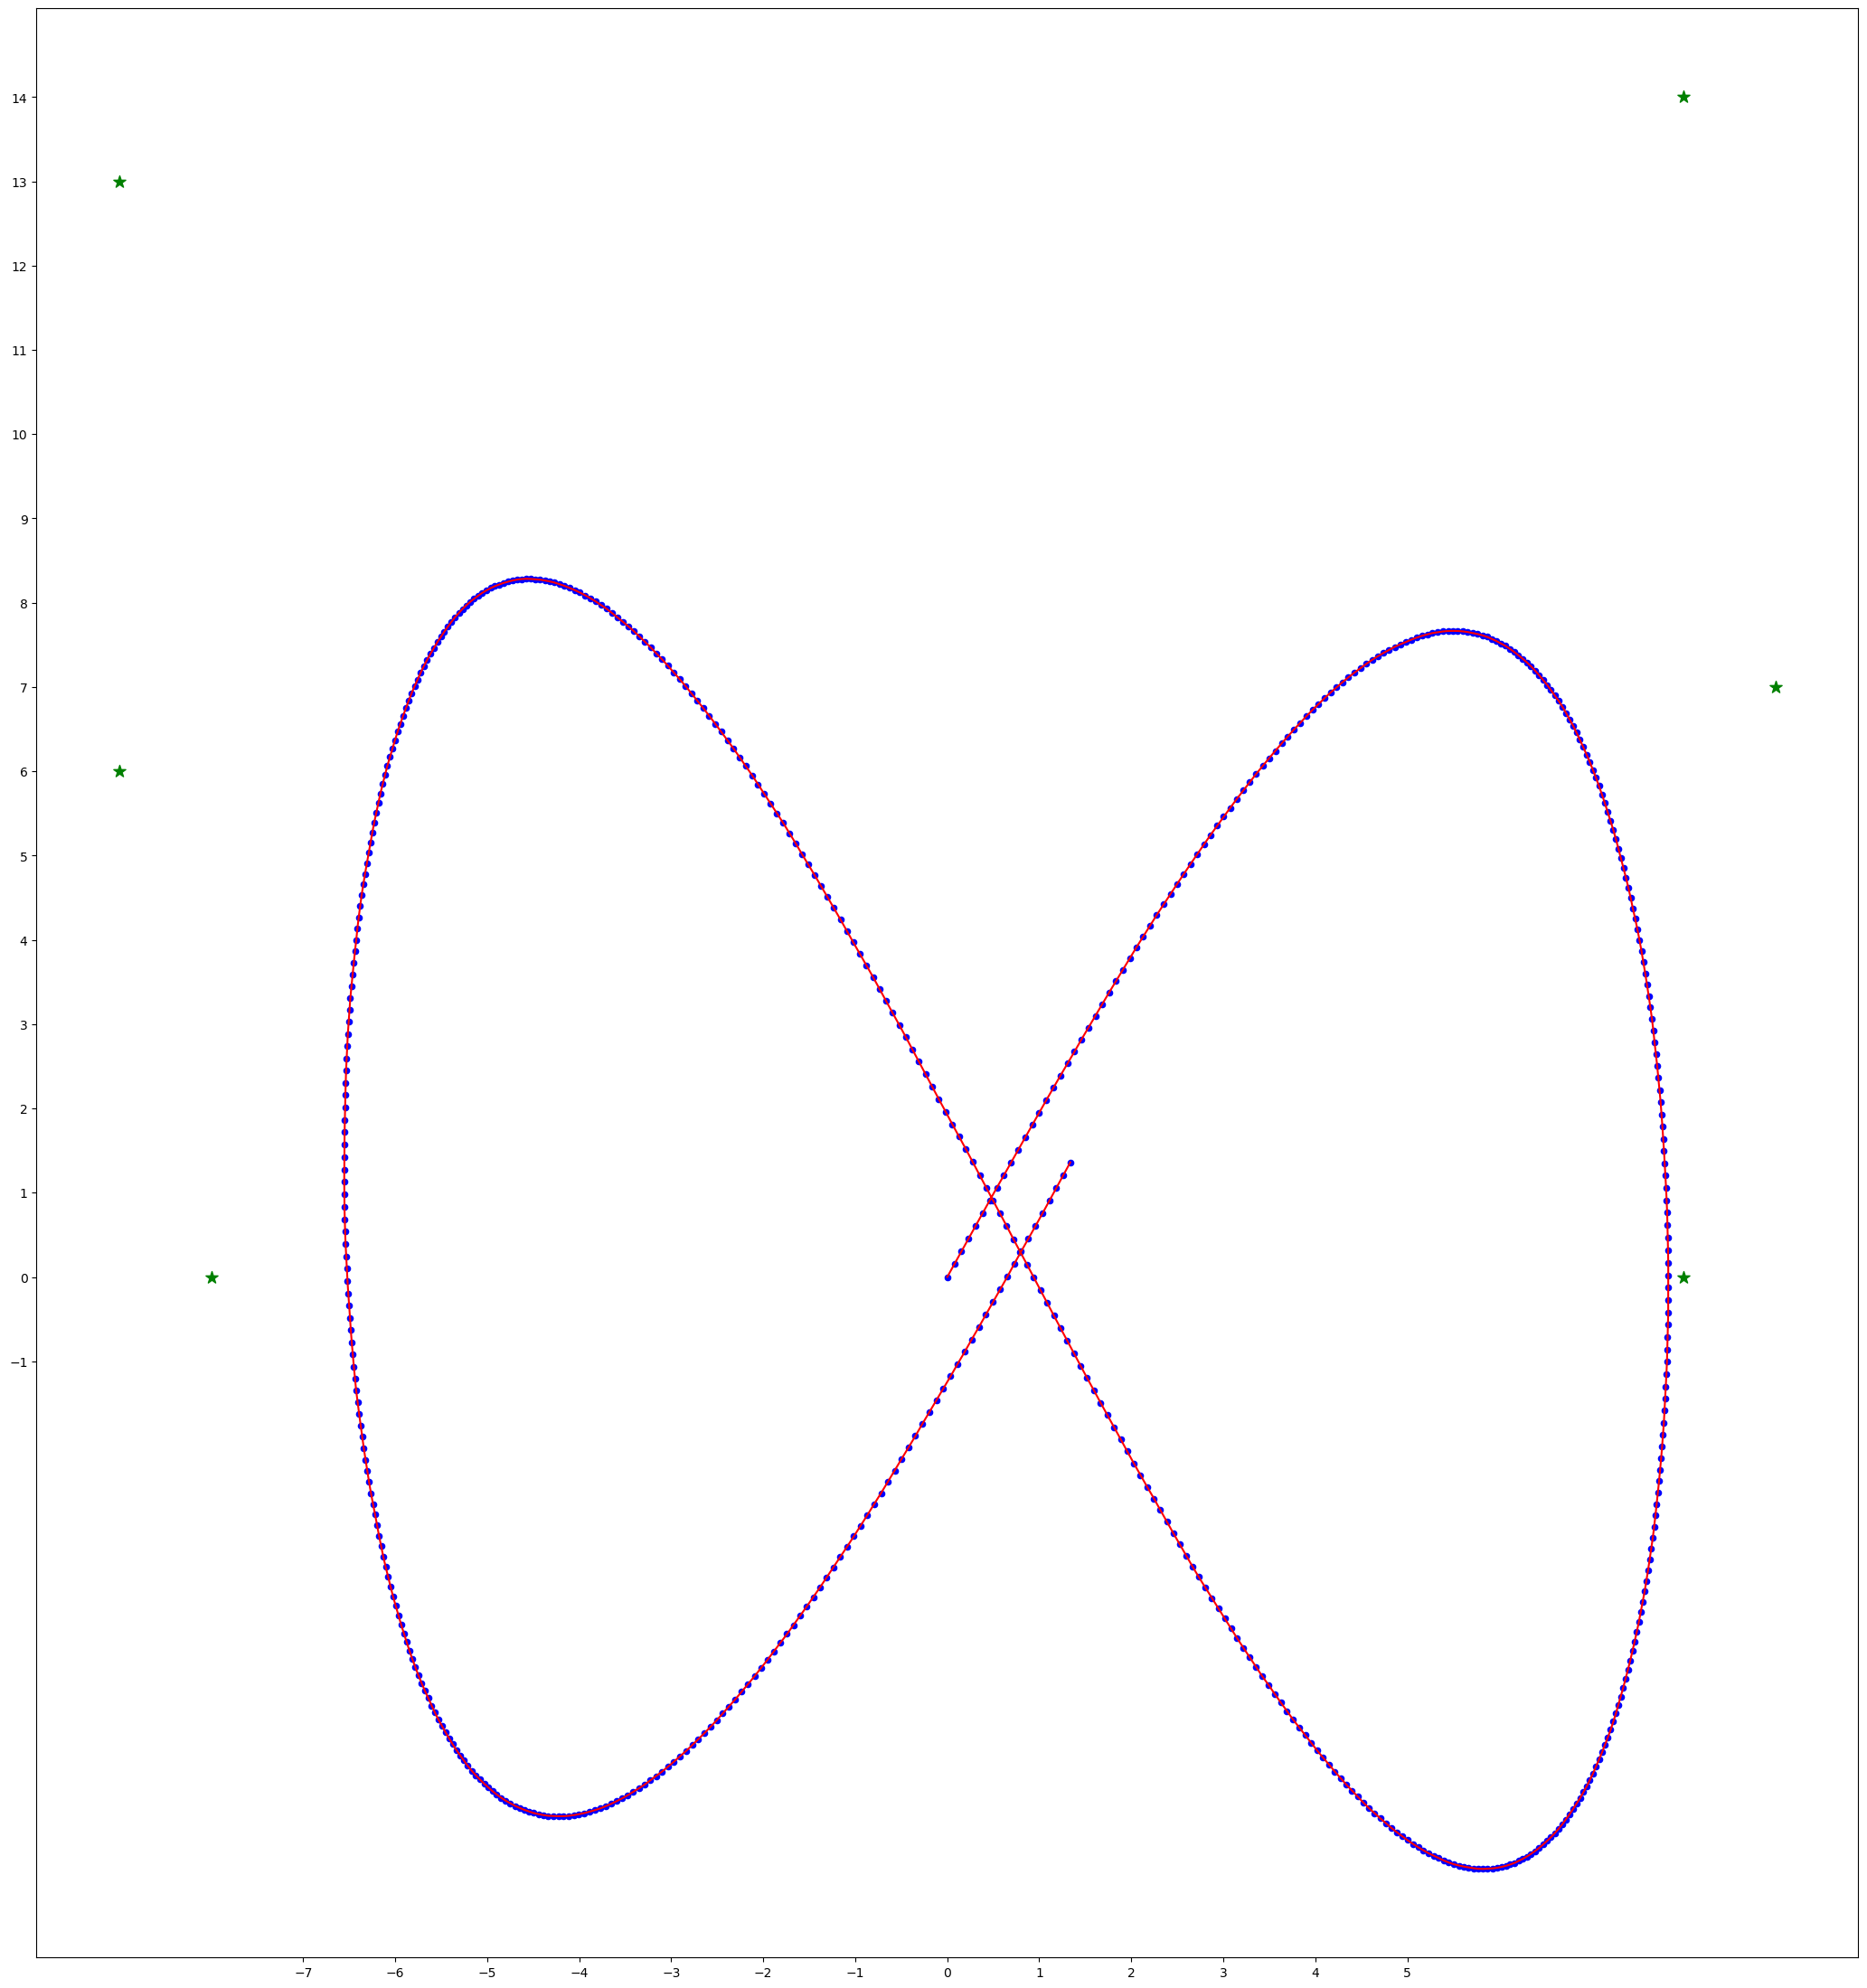

In [20]:
# Create a larger figure
plt.figure(figsize=(26, 28))  # Adjust the figsize (width, height) as needed

x_robot = [value[0] for value in nodes_robot.values()]
y_robot = [value[1] for value in nodes_robot.values()]

# Create a scatter plot with blue circles
plt.scatter(x_robot, y_robot, color='blue', marker='o', s=20)

# Create red lines connecting the points
plt.plot(x_robot, y_robot, color='red')


######################### APs ##########################
x_AP = [value[0] for value in nodes_AP.values()]
y_AP = [value[1] for value in nodes_AP.values()]
plt.scatter(x_AP, y_AP, color='green', marker='*', s=100)
########################################################

# Set custom tick positions and labels for the x-axis
x_ticks_positions = np.arange(-7, 6, 1)  # Start at 0, end at 6 (exclusive), step by 1
plt.xticks(x_ticks_positions)

# Set custom tick positions and labels for the y-axis
y_ticks_positions = np.arange(-1, 15, 1)
plt.yticks(y_ticks_positions)

# Show the plot
plt.show()

### Measurements

In [21]:
# Parameters for the Gaussian noise
mean_measurement = 0  # Mean of the Gaussian distribution
stddev_measurement = 0.05  # Standard deviation of the Gaussian distribution
size = len(x_gt) 

# Generate Gaussian noise
measurement_noise = np.random.normal(mean_measurement, stddev_measurement, size)

In [22]:
d_AP1 = np.sqrt((x_gt - x_AP[0])**2 + (y_gt - y_AP[0])**2) + measurement_noise
d_AP2 = np.sqrt((x_gt - x_AP[1])**2 + (y_gt - y_AP[1])**2) + measurement_noise
d_AP3 = np.sqrt((x_gt - x_AP[2])**2 + (y_gt - y_AP[2])**2) + measurement_noise
d_AP4 = np.sqrt((x_gt - x_AP[3])**2 + (y_gt - y_AP[3])**2) + measurement_noise
d_AP5 = np.sqrt((x_gt - x_AP[4])**2 + (y_gt - y_AP[4])**2) + measurement_noise
d_AP6 = np.sqrt((x_gt - x_AP[5])**2 + (y_gt - y_AP[5])**2) + measurement_noise

In [23]:
distances_robot = {key: [d_AP1[key], d_AP2[key], d_AP3[key], d_AP4[key], d_AP5[key], d_AP6[key]] for key in range(len(x_gt))}

In [24]:
# For "not seeing" AP
threshold = 10.0

for ID, ID_distances in distances_robot.items():
    for i in range(len(ID_distances)):
        if ID_distances[i] > threshold:
            ID_distances[i] = -1.0

### Convert distances to RSS

In [25]:
rss_robot = {key: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0] for key in range(len(x_gt))}

In [26]:
# f should be in MHz, d in km
f = 2.4 * 1000 # MHz
# -1 denotes highest RSS, -100 denotes lowest RSS, 0 - Not Detected
for ID, ID_distances in distances_robot.items():
    for i in range(len(ID_distances)):
        # Convert distance to RSS only if AP is detected (i.e. only if distance is NOT -1)
        if ID_distances[i] != -1.0:
            rss_robot[ID][i] = -((20.0 * np.log10(np.divide(ID_distances[i], 1000.0))) + (20.0 * np.log10(f)) + 32.44)

# Fingerprint Similarity

In [27]:
def overlap_APs(fi,fj):
    fi = np.array(fi)
    fj = np.array(fj)
    fi_mask = (fi < 0.0)
    fj_mask = (fj < 0.0)
    overlap_array_mask = np.array((fi_mask & fj_mask))
    return overlap_array_mask

In [28]:
def detection_likelihood(fi, fj):
    fi = np.array(fi)
    fj = np.array(fj)
    fi_mask = (fi < 0.0)
    fj_mask = (fj < 0.0)
    Li = np.sum(fi_mask)
    Lj = np.sum(fj_mask)
    H = np.sum(overlap_APs(fi,fj))
    dl = np.divide(H, Li + Lj - H)
    return dl

In [29]:
def signal_strength_likelihood(fi, fj):
    sigma = 0.5
    overlap_array_mask = overlap_APs(fi, fj)
    overlap_indices = np.where(overlap_array_mask)[0]
    H = np.sum(overlap_array_mask)
    prod = 1.0
    for idx in overlap_indices:
        a = np.power(fi[idx] - fj[idx], 2)
        b = np.divide(a, 2*np.power(sigma,2))
        c = np.exp(-b)
        prod = prod * c
    
    #ssl = prod ** (np.divide(1,H))
    ssl = prod
    return ssl

In [30]:
def similarity_score(fi, fj):
    dl = detection_likelihood(fi, fj)
    ssl = signal_strength_likelihood(fi, fj)
    sim = dl * ssl
    
    return sim

### Create dictionary, where key is position ID, and value is list of FP similarities with all positions (including itself)

In [31]:
similarities_dict = {}

for ID1, RSS1 in rss_robot.items():
    similarities = []
    for ID2, RSS2 in rss_robot.items():
        sim = similarity_score(RSS1, RSS2)
        similarities.append(sim)
    
    similarities_dict[ID1] = similarities

### Create dictionary, where ky is position ID, and value is cummulative distance so far, up to that point

In [32]:
positions_cum_distances_dict = {}
positions_cum_distances_dict[0] = 0
for i in range(1, len(x_gt)):
    positions_cum_distances_dict[i] = positions_cum_distances_dict[i-1] + np.linalg.norm(np.array(nodes_robot[i]) - np.array(nodes_robot[i-1]))

## DataFrame creation

In [33]:
columns = ['ID', 'x', 'y', 'd1', 'd2', 'd3', 'd4', 'd5', 'd6', 'rss1', 'rss2', 'rss3', 'rss4', 'rss5', 'rss6', 'similarities','traveled_distance',
          'loop_closure_candidates']
df = pd.DataFrame(columns=columns)

In [ ]:
for i in range(0, len(x_gt)):
    df.loc[i,'ID'] = i
    df.loc[i,'x'] = x_odometry[i]
    df.loc[i,'y'] = y_odometry[i]
    df.loc[i,'d1'] = d_AP1[i]
    df.loc[i,'d2'] = d_AP2[i]
    df.loc[i,'d3'] = d_AP3[i]
    df.loc[i,'d4'] = d_AP4[i]
    df.loc[i,'d5'] = d_AP5[i]
    df.loc[i,'d6'] = d_AP6[i]
    df.loc[i,'rss1'] = rss_robot[i][0]
    df.loc[i,'rss2'] = rss_robot[i][1]
    df.loc[i,'rss3'] = rss_robot[i][2]
    df.loc[i,'rss4'] = rss_robot[i][3]
    df.loc[i,'rss5'] = rss_robot[i][4]
    df.loc[i,'rss6'] = rss_robot[i][5]
    df.loc[i,'similarities'] = similarities_dict[i]
    df.loc[i,'traveled_distance'] = positions_cum_distances_dict[i]

### Loop Closure Part

#### Loop Closure Conditions:

1. FP similarity between two positions is greater than certain threshold
2. Difference of cummulative distance (i.e. distance traveled so far) between two positions is greater than certain threshold

In [ ]:
df.head(3)

#### Implementation

In [ ]:
# Window size
w = 6

In [ ]:
def find_j_star(df, i, j, tau, w):
    den = 0.0
    num = np.array([0,0])
    for k in range(-w,w+1):
        l = (j+k) # notation from paper (l)
        sim_itau_l = similarity_score(df.loc[i+tau, ['rss1', 'rss2', 'rss3', 'rss4', 'rss5', 'rss6']], df.loc[l, ['rss1', 'rss2', 'rss3', 'rss4', 'rss5', 'rss6']])
        
        den = den + sim_itau_l
        num = num + (sim_itau_l * df.loc[l, ['x', 'y']])

    j_star = np.divide(num, den)
    return j_star

In [ ]:
def find_correspondences(df, i, j, w):
    correspondences_indices = []
    for tau in range(-int(w/2),int(w/2) + 1):
        correspondence = []
        correspondence.append(i+tau)
        x_j_star = find_j_star(df, i, j, tau, w)
        
        # Find closest point in j-sequence to the x_j_star
        j_seq = df.loc[(j-w-1):(j+w+1), ['ID','x','y']]
        j_seq['Distance'] = j_seq.apply(lambda row: np.linalg.norm(np.array(x_j_star) - np.array([row['x'], row['y']])), axis=1)
        closest_index_j = j_seq['Distance'].idxmin()
        correspondence.append(closest_index_j)
        correspondences_indices.append(correspondence)
    
    return correspondences_indices

In [ ]:
def find_transformation(df, i, j, w):
    correspondences = find_correspondences(df, i, j, w)
    return correspondences

In [ ]:
def ICP_known_correspondences(df, correspondences):
    i_n = []
    j_n = []
    for k in range(0, len(correspondences)):
        i_n.append(correspondences[k][0])
        j_n.append(correspondences[k][1])
    
    
    x_n = np.array(df.loc[i_n,['x','y']]).transpose() # 2xn
    y_n = np.array(df.loc[j_n,['x','y']]).transpose() # 2xn
    
    x_0 = np.divide(np.sum(x_n, axis=1), len(x_n)).reshape((-1,1)) # 2x1
    y_0 = np.divide(np.sum(y_n, axis=1), len(y_n)).reshape((-1,1)) # 2x1
    
    x_n_prime = x_n - x_0 # 2xn
    y_n_prime = y_n - y_0 # 2xn
    
    
    #Calculate covariance matrix (2x2)
    H = np.matmul(x_n_prime, y_n_prime.transpose())
    
    print(np.array(H))
    
    #Calculate singular value decomposition (SVD)
    U, D, V_T = np.linalg.svd(H) #the SVD of linalg gives you Vt
    D = np.diag(D)
    V = V_T.transpose()
    
    R = np.matmul(V, U.transpose())
    #R = np.matmul(U, np.transpose(V))
    t = y_0 - np.matmul(R,x_0)
    
    return R,t

In [ ]:
LC_pairs = []
LC_transformations = []
for i in range(0, len(df)):
    flag = False
    for j in range(0, i):
        if((df.loc[i,'similarities'][j] > 0.75) and (np.fabs(df.loc[i, 'traveled_distance'] - df.loc[j, 'traveled_distance'])) > 20.0):
            print('Finding correspondences ...')
            correspondences_indices = find_transformation(df, i, j, w)
            print('Finding transformation (ICP with known correspondences) ...')
            R_star, t_star = ICP_known_correspondences(df, correspondences_indices)
            print(i)
            print(j)
            print(R_star)
            print(t_star)
            flag = True
            break
            if(loss(T_star, df, i, j, w)):
                pair = [i,j]
                LC_pairs.append[pair]
                LC_transformations.append(T_star)
    if(flag==True):
        break